In [1]:
import os
import argparse
import functools
import itertools

from bboxes_utils import bboxes_from_fast_rcnn

os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import numpy as np
import tensorflow as tf
from tqdm.auto import tqdm
import math

DIM = 224

from svhn_dataset import SVHN
from svhn_augmentations import DatasetFactory
from svhn_anchors import AnchorsFactory
from svhn_competition import RetinaNet, create_retinanet_binary_focal_crossentropy, create_retinanet_bbox_huber
from lovely_numpy import lo as _lo
import matplotlib as mpl
import matplotlib.pyplot as plt

def lo(x):
    if isinstance(x, tf.Tensor):
        x = x.numpy()

    return _lo(x)

In [2]:
svhn = SVHN()

Metal device set to: Apple M1 Max


In [4]:
anchors_factory = AnchorsFactory(levels=(3, 7), ratios=[0.5,1], scales=[0.5,1])

In [5]:
rnet = RetinaNet(num_classes=SVHN.LABELS, backbone="resnet", levels=(3, 7), n_anchors=anchors_factory.anchors_per_unit)
rnet.compile(loss={'classes': create_retinanet_binary_focal_crossentropy(), 'bboxes': create_retinanet_bbox_huber()})

In [7]:
dataset_factory = DatasetFactory(svhn=svhn, anchors_factory=anchors_factory, batch_size=1, iou_threshold=0.3, bg_iou_threshold=0.2, shuffle_train=False)

In [8]:
dataset = dataset_factory.build('train')
dataset_p = dataset_factory.build_packed('train')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [9]:
x, y = next(iter(dataset))

In [19]:
def iterate_images(dataset):
    for x, y in dataset:
        n_imgs = x.shape[0]
        classes = y['classes']
        bboxes = y['bboxes']
        for i in range(n_imgs):
            yield x[i], {'classes': classes[i], 'bboxes': bboxes[i]}

In [20]:
it = iter(iterate_images(dataset))

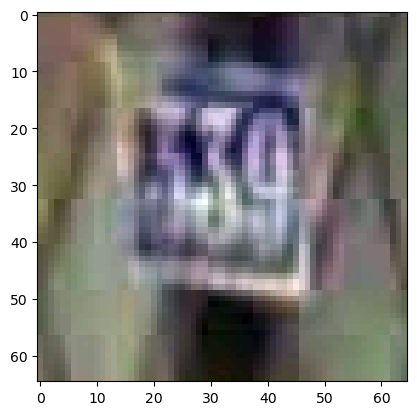

In [22]:
x, y_true = next(it)
img = ((x - tf.reduce_min(x, axis=(0, 1))) / (tf.reduce_max(x, axis=(0, 1)) - tf.reduce_min(x, axis=(0, 1))))

plt.imshow(img)
plt.show()